In [1]:
import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F

In [2]:
# data_path = '/raid1/ml4ao/torch_format_data/V2full_500/'
# data_path = '/raid1/ml4ao/torch_format_data/V3full_500/' # -> V5
data_path = '/raid1/ml4ao/torch_format_data/V4full_500/' # -> V6
output_path = '/raid1/ml4ao/torch_data/'

In [3]:
output_data_name = 'tensor_data_olmodes4_V9'
labels_data_name = 'tensor_data_labels4_V9'

In [4]:
filenames= ['comm', 'deltaComm', 'SEEING', 'ATMO_l0', 'ATMO_heigths', 'ATMO_cn2', 'WIND_SPEED', 'srRes']

In [5]:
indata = {}

#m = torch.nn.AvgPool1d(2, stride=2)

for idx in range(20):
    for ff in filenames:
        time.sleep(1)
        filename = os.path.join(data_path, ff+'_'+str(idx)+'.pl')
        print(filename)
        if os.path.exists(filename):
            # load and substitute nan with 0
            moreData = torch.nan_to_num(torch.load(filename))
            indata[ff] = moreData
            print(indata[ff].shape)
        else:
            break
    nTNs = indata['SEEING'].shape[0]
    print(nTNs)
    # compute tau0
    r0 = 0.9759 * 0.5 / (indata['SEEING'] * 4.848)
    wind_speed = indata['WIND_SPEED']
    print(wind_speed.shape)
    wind_speed_average = torch.mean(wind_speed, dim=1)
    print(wind_speed_average.shape)
    tau0 = 0.314 * r0 / wind_speed_average * 1e3
    
    # compute ol_modes
    print("indata['deltaComm'].shape", indata['deltaComm'].shape)
    
    #space_ts = 1
    #start_ts = 100
    #end_ts = 228
    
#    space_ts = 10
#    start_ts = 100
#    end_ts = 100 + 128*space_ts
#    ol_modes = indata['deltaComm'][:,:200, start_ts+2:end_ts+2:space_ts] + indata['comm'][:,:200, start_ts:end_ts:space_ts]
    ol_modes = indata['deltaComm'][:,:200, 2:] + indata['comm'][:,:200, :-2]
#    ol_modes = m(torch.abs(ol_modes))
    print("ol_modes.shape", ol_modes.shape)
    labels4 = torch.empty(nTNs, 8)
    labels4[:, 0] = indata['SEEING']
    labels4[:, 1] = indata['ATMO_l0']
    labels4[:, 2] = wind_speed_average
#    labels4[:, 3] = torch.mean(indata['srRes'][:,start_ts:end_ts:space_ts],dim=1)
    labels4[:, 3] = torch.mean(indata['srRes'], dim=1)
    labels4[:, 4] = wind_speed[:, 0]
    labels4[:, 5] = wind_speed[:, 1]
    labels4[:, 6] = wind_speed[:, 2]
    labels4[:, 7] = wind_speed[:, 3]
        
    torch.save(ol_modes, os.path.join(output_path, output_data_name) + '_'+str(idx)+'.pt')
    torch.save(labels4, os.path.join(output_path, labels_data_name) + '_'+str(idx)+'.pt')

/raid1/ml4ao/torch_format_data/V4full_500/comm_0.pl
torch.Size([500, 500, 1718])
/raid1/ml4ao/torch_format_data/V4full_500/deltaComm_0.pl
torch.Size([500, 500, 1718])
/raid1/ml4ao/torch_format_data/V4full_500/SEEING_0.pl
torch.Size([500])
/raid1/ml4ao/torch_format_data/V4full_500/ATMO_l0_0.pl
torch.Size([500])
/raid1/ml4ao/torch_format_data/V4full_500/ATMO_heigths_0.pl
torch.Size([500, 4])
/raid1/ml4ao/torch_format_data/V4full_500/ATMO_cn2_0.pl
torch.Size([500, 4])
/raid1/ml4ao/torch_format_data/V4full_500/WIND_SPEED_0.pl
torch.Size([500, 4])
/raid1/ml4ao/torch_format_data/V4full_500/srRes_0.pl
torch.Size([500, 1718])
500
torch.Size([500, 4])
torch.Size([500])
indata['deltaComm'].shape torch.Size([500, 500, 1718])
ol_modes.shape torch.Size([500, 200, 1716])
/raid1/ml4ao/torch_format_data/V4full_500/comm_1.pl
torch.Size([500, 500, 1718])
/raid1/ml4ao/torch_format_data/V4full_500/deltaComm_1.pl
torch.Size([500, 500, 1718])
/raid1/ml4ao/torch_format_data/V4full_500/SEEING_1.pl
torch.Size(

In [6]:
ol_modes = None
labels4 = None
for idx in range(20):    
    ol_modes_i = torch.load(os.path.join(output_path, output_data_name) + '_'+str(idx)+'.pt')
    labels4_i = torch.load(os.path.join(output_path, labels_data_name) + '_'+str(idx)+'.pt')
    if idx==0:
        ol_modes = ol_modes_i
        labels4 = labels4_i
    else:
        ol_modes = torch.cat((ol_modes, ol_modes_i))
        labels4 = torch.cat((labels4, labels4_i))

print(ol_modes.shape)
print(labels4.shape)
torch.save(ol_modes, os.path.join(output_path, output_data_name) + '.pt')
torch.save(labels4, os.path.join(output_path, labels_data_name) + '.pt')

torch.Size([10000, 200, 1716])
torch.Size([10000, 8])


0 mean,std: (tensor(0.4609), tensor(1.2039))


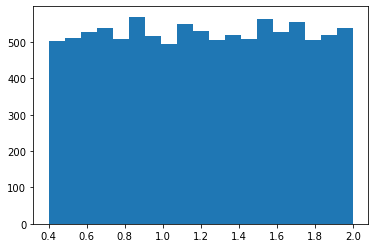

1 mean,std: (tensor(11.2601), tensor(20.3407))


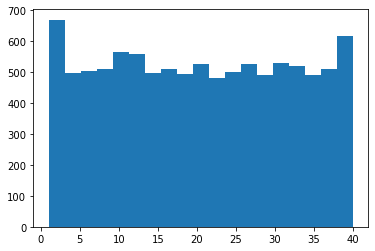

2 mean,std: (tensor(4.2481), tensor(21.2280))


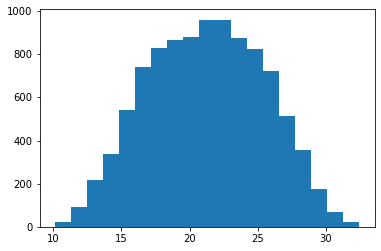

3 mean,std: (tensor(0.2026), tensor(0.6962))


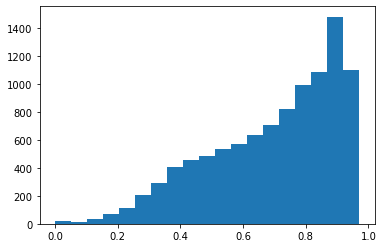

4 mean,std: (tensor(3.4403), tensor(10.0495))


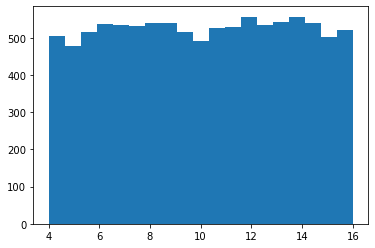

5 mean,std: (tensor(5.8110), tensor(14.8594))


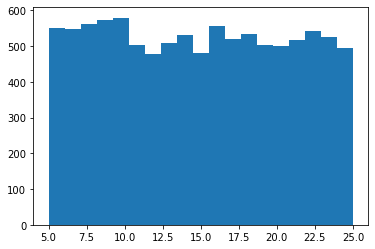

6 mean,std: (tensor(5.7495), tensor(14.9963))


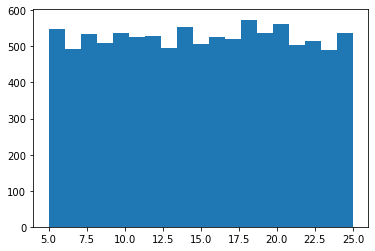

7 mean,std: (tensor(14.4991), tensor(45.0068))


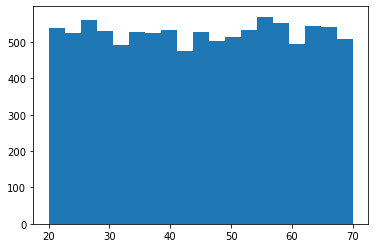

In [7]:
for ll in range(8):
    print(ll, 'mean,std:', torch.std_mean(labels4[:, ll]))
    lv = labels4[:, ll].numpy()
    num_bins = 20 # <-- Change here - Specify total number of bins for histogram
    plt.hist(lv.ravel(), bins=np.linspace(np.min(lv), np.max(lv), num=num_bins)) #<-- Change here.  Note the use of ravel.
    plt.show()